# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model.
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [ ]:
%pip install hf_xet
%pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import CrossEncoder
import torch
import math
import matplotlib.pyplot as plt
import yfinance as yf
import os
from tqdm import tqdm

## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/FZ4025 - Fintech e innovación digital en finanzas/Week 5/"
os.chdir(DIR)

Mounted at /content/drive


In [ ]:
df_news = pd.read_csv('df_news.csv')
df_news.drop_duplicates('SUMMARY', inplace=True)
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


In [ ]:
df_meta = pd.read_csv('df_metadata.csv')
display(df_meta)

,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services
...,...,...,...,...
485,XEL,Xcel Energy Inc.,Utilities,Utilities - Regulated Electric
486,XYL,Xylem Inc.,Industrials,Specialty Industrial Machinery
487,YUM,"Yum! Brands, Inc.",Consumer Cyclical,Restaurants
488,ZBH,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


In [ ]:
# CODE HERE
# Use as many coding cells as you need
model_name = "cross-encoder/nli-deberta-v3-base"
model = CrossEncoder(model_name)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [ ]:
positive_evaluation = [(title, 'This news headline has a positive tone') for title in df_news['TITLE']]
negative_evaluation = [(title, 'This news headline has a negative tone') for title in df_news['TITLE']]

positive_scores = model.predict(positive_evaluation, apply_softmax = True)
negative_scores = model.predict(negative_evaluation, apply_softmax = True)

pos_prob = positive_scores[:,2]
neg_prob = negative_scores[:,2]

In [ ]:
df_news["POSITIVE_PROB"] = pos_prob
df_news["NEGATIVE_PROB"] = neg_prob
df_news["SENTIMENT"] = df_news["POSITIVE_PROB"] - df_news["NEGATIVE_PROB"]
display(df_news.head())

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,0.964313,0.020884,0.943429
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,0.994110,0.998028,-0.003918
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,0.998623,0.041682,0.956942
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,0.999596,0.997867,0.001729
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...,0.002013,0.998626,-0.996613


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

In [ ]:
# CODE HERE
# Use as many coding cells as you need

df_news["PUBLICATION_DATE"] = pd.to_datetime(df_news["PUBLICATION_DATE"]).dt.date

# Group and average sentiment
df_daily_sentiment = df_news.groupby("PUBLICATION_DATE")["SENTIMENT"].mean().reset_index()
df_daily_sentiment.rename(columns={"SENTIMENT": "DAILY_SENTIMENT"}, inplace=True)

display(df_daily_sentiment.head())

,PUBLICATION_DATE,DAILY_SENTIMENT
0,2024-07-12,-0.024298
1,2024-07-22,0.023326
2,2024-08-19,0.005307
3,2024-09-13,0.000213
4,2024-10-26,0.914759


In [ ]:
unique_tickers = df_news["TICKER"].unique().tolist()

In [ ]:
start_date = df_news["PUBLICATION_DATE"].min()
end_date = df_news["PUBLICATION_DATE"].max()

In [ ]:
prices = yf.download(unique_tickers, start=start_date, end=end_date)
if isinstance(prices.columns, pd.MultiIndex):
    prices.columns = [f"{attr}_{ticker}" for attr, ticker in prices.columns]

returns_df = pd.DataFrame(index=prices.index)
for ticker in unique_tickers:
    col_name = f"Close_{ticker}"
    if col_name in prices.columns:
        returns_df[ticker] = prices[col_name].pct_change()


returns_df["DAILY_AVG_RETURN"] = returns_df.mean(axis=1, skipna=True)
returns_df = returns_df.reset_index()
returns_df["Date"] = returns_df["Date"].dt.date

[*********************100%***********************]  487 of 487 completed


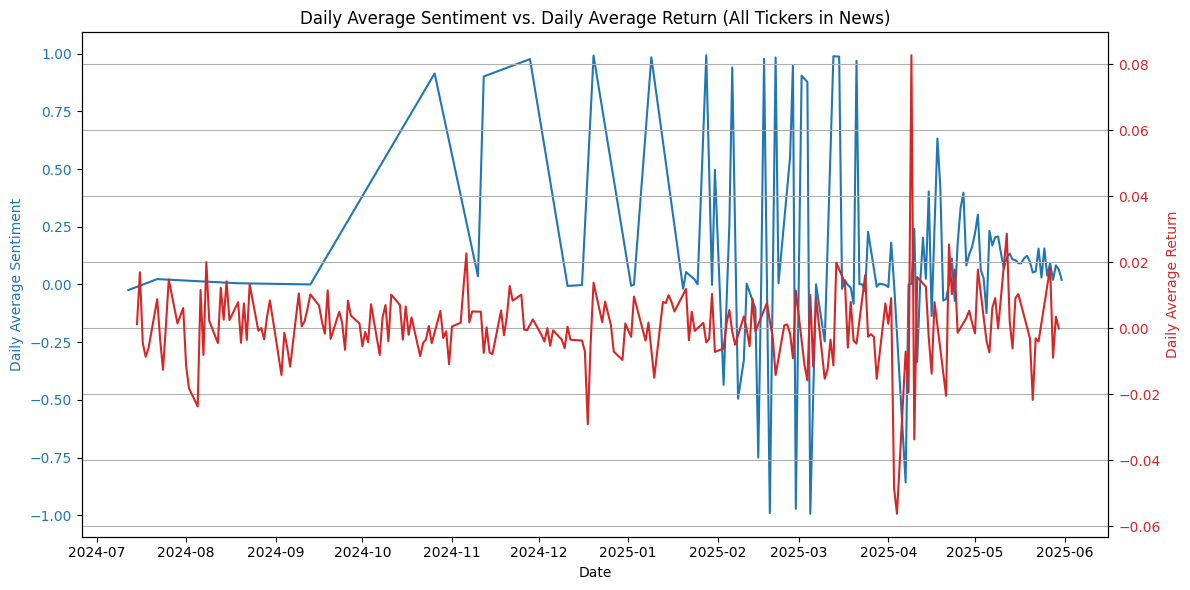

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel("Daily Average Sentiment", color=color)
ax1.plot(df_daily_sentiment["PUBLICATION_DATE"], df_daily_sentiment["DAILY_SENTIMENT"],
         color=color, label="Sentiment")
ax1.tick_params(axis='y', labelcolor=color)

# Right y-axis: Return
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Daily Average Return", color=color)
ax2.plot(returns_df["Date"], returns_df["DAILY_AVG_RETURN"],
         color=color, label="Return")
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Daily Average Sentiment vs. Daily Average Return (All Tickers in News)")
fig.tight_layout()
plt.grid(True)
plt.show()

## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


In [ ]:
# CODE HERE
# Use as many coding cells as you need

prices = yf.download(unique_tickers, start=start_date, end=end_date)["Close"]

[*********************100%***********************]  487 of 487 completed


In [ ]:
# Daily percentage changes for each ticker
daily_returns = prices.pct_change()

# Average across tickers each day (equal-weighted portfolio)
avg_daily_returns = daily_returns.mean(axis=1)

# Drop first NaN
avg_daily_returns = avg_daily_returns.dropna()


In [ ]:
portfolio_value = (1 + avg_daily_returns).cumprod()
portfolio_value.iloc[0] = 1.0
portfolio_df = portfolio_value.reset_index()
portfolio_df.columns = ["DATE", "PORTFOLIO_VALUE"]


In [ ]:
portfolio_df["DATE"] = pd.to_datetime(portfolio_df["DATE"])
df_daily_sentiment["PUBLICATION_DATE"] = pd.to_datetime(df_daily_sentiment["PUBLICATION_DATE"])

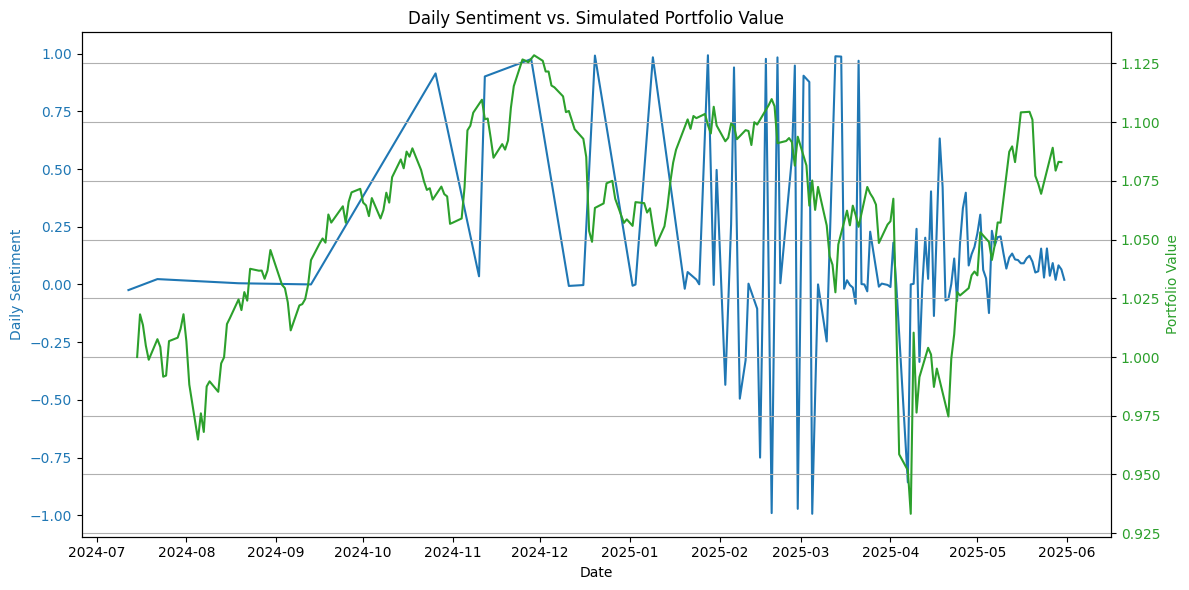

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis (Sentiment)
color = "tab:blue"
ax1.set_xlabel("Date")
ax1.set_ylabel("Daily Sentiment", color=color)
ax1.plot(df_daily_sentiment["PUBLICATION_DATE"], df_daily_sentiment["DAILY_SENTIMENT"],
         color=color, label="Sentiment")
ax1.tick_params(axis="y", labelcolor=color)

# Right y-axis (Portfolio Value)
ax2 = ax1.twinx()
color = "tab:green"
ax2.set_ylabel("Portfolio Value", color=color)
ax2.plot(portfolio_df["DATE"], portfolio_df["PORTFOLIO_VALUE"],
         color=color, label="Portfolio Value")
ax2.tick_params(axis="y", labelcolor=color)

plt.title("Daily Sentiment vs. Simulated Portfolio Value")
fig.tight_layout()
plt.grid(True)
plt.show()

## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



In [ ]:
# CODE HERE
# Use as many coding cells as you need

df_merge = pd.merge(df_news, df_meta, on="TICKER", how="left")


df_merge["PUBLICATION_DATE"] = pd.to_datetime(df_merge["PUBLICATION_DATE"], errors="coerce")
df_merge["MONTH"] = df_merge["PUBLICATION_DATE"].dt.to_period("M")


monthly_sentiment = (
    df_merge.groupby(["SECTOR", "MONTH"])["SENTIMENT"]
    .mean()
    .reset_index()
)

# Optional: headline counts
headline_counts = (
    df_merge.groupby(["SECTOR", "MONTH"])["SENTIMENT"]
    .count()
    .reset_index(name="HEADLINES")
)

display(headline_counts.sort_values("MONTH", ascending=False))

,SECTOR,MONTH,HEADLINES
4,Basic Materials,2025-05,135
14,Consumer Defensive,2025-05,270
17,Energy,2025-05,172
11,Consumer Cyclical,2025-05,409
7,Communication Services,2025-05,144
43,Real Estate,2025-05,188
33,Industrials,2025-05,539
52,Utilities,2025-05,209
46,Technology,2025-05,636
28,Healthcare,2025-05,446


In [ ]:
start_date = "2025-02-01"
end_date = "2025-05-31"

tickers = df_meta["TICKER"].unique().tolist()
prices = yf.download(tickers, start=start_date, end=end_date)["Close"]

# Monthly returns per ticker
monthly_prices = prices.resample("M").last()
monthly_returns = monthly_prices.pct_change()

# Map tickers to sectors
ticker_to_sector = dict(zip(df_meta["TICKER"], df_meta["SECTOR"]))

# Compute sector monthly returns (equal-weighted)
sector_monthly_returns_wide = monthly_returns.groupby(ticker_to_sector, axis=1).mean()
sector_monthly_returns = sector_monthly_returns_wide.reset_index()
sector_monthly_returns = sector_monthly_returns.melt(
    id_vars="Date",
    var_name="SECTOR",
    value_name="RETURN"
)

sector_monthly_returns["MONTH"] = sector_monthly_returns["Date"].dt.to_period("M")
sector_monthly_returns = sector_monthly_returns.drop(columns=["Date"]).dropna()


[*********************100%***********************]  490 of 490 completed


In [ ]:
may_sentiment = monthly_sentiment[monthly_sentiment["MONTH"] == "2025-05"]
may_returns = sector_monthly_returns[sector_monthly_returns["MONTH"] == "2025-05"]

comparison_df = pd.merge(
    may_sentiment[["SECTOR", "SENTIMENT"]],
    may_returns[["SECTOR", "RETURN"]],
    on="SECTOR",
    how="inner"
)


In [ ]:
correlation = comparison_df["SENTIMENT"].corr(comparison_df["RETURN"])
print("Correlation between May sentiment and May returns:", round(correlation, 3))


Correlation between May sentiment and May returns: -0.186


In [ ]:
print(comparison_df.sort_values("SECTOR", ascending = True).reset_index(drop=True))


                    SECTOR  SENTIMENT    RETURN
0          Basic Materials   0.158076  0.029613
1   Communication Services   0.053679  0.043514
2        Consumer Cyclical   0.036126  0.056382
3       Consumer Defensive   0.047173  0.000008
4                   Energy  -0.003138  0.029434
5       Financial Services   0.060473  0.061068
6               Healthcare   0.118411  0.000100
7              Industrials   0.108424  0.074589
8              Real Estate   0.250414  0.010360
9               Technology   0.129340  0.075285
10               Utilities   0.138633  0.032967


### **Question 1.** Which sectors *looked* good in the news? How did they perform?


YOUR WRITTEN RESPONSE HERE

The sectors that looked best in the news were Real Estate with 0.250 sentiment, followed by Basic Materials at 0.158, Healthcare at 0.118, and Technology at 0.129. However, their performance told a different story. Real Estate, despite having the most positive news coverage, delivered only 1.04% returns, making it one of the worst performers. Healthcare also disappointed with essentially flat performance at 0.01% returns despite very positive sentiment. Basic Materials managed moderate 2.96% returns, while Technology actually performed well with 7.53% returns. This reveals a clear disconnect between media coverage and actual market performance, suggesting that positive news sentiment doesn't reliably translate to strong returns.


### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


YOUR WRITTEN RESPONSE HERE

Energy stands out as having negative sentiment (-0.003) yet delivering solid 2.94% returns. This suggests the market may have been overly pessimistic about energy prospects in the news coverage. Communication Services also had relatively low sentiment (0.054) but delivered 4.35% returns, indicating potential undervaluation in media coverage relative to actual business fundamentals.

### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

YOUR WRITTEN RESPONSE HERE

No, I would not invest based on sentiment alone. The data clearly demonstrates that positive news sentiment does not reliably predict positive returns. Real Estate's 25% sentiment with 1% returns and Healthcare's 12% sentiment with flat performance show that media coverage can be misleading. Sentiment appears to capture convenient narrative and hype rather than business value drivers. A robust investment strategy should incorporate sentiment as one factor among many, including financial metrics, valuation ratios, and macroeconomic conditions.

### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

YOUR WRITTEN RESPONSE HERE

To test sentiment analysis more rigorously, I would start by extending the analysis to cover multiple years of data across different market cycles to avoid drawing conclusions from a single month's performance. I would also control for different market conditions by separating the analysis during bull markets, bear markets, and high volatility periods since sentiment might behave differently in each regime. The sentiment signals should be benchmarked against traditional fundamental analysis metrics like price-to-earnings ratios and earnings growth to see if sentiment adds incremental value. Any backtesting must include realistic transaction costs and market impact since frequent trading based on sentiment could erode returns. Finally, evaluation should focus on risk-adjusted returns using metrics like Sharpe ratios and maximum drawdown rather than just raw returns, since a strategy might show positive returns but with unacceptable risk levels.
